In [1]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=c5d61cd9f1de5855527a2a0790b29319eee651213770f3d1a1b7b67fba3bda79
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [53]:
import torch
from torch import Tensor
from torch import nn
from torch.nn import Module, ModuleList
from torch.optim import Adam
import torch.autograd as autograd


from pyDOE import lhs
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
torch.set_default_dtype(torch.float)

# Генератор случайных чисел в PyTorch
torch.manual_seed(1234)

# Генератор случайных чисел в Numpy
np.random.seed(1234)

# Конфигурация устройтсва, на котором будут производиться вычисления
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda


**Рассмотрим решение задачи аппроксимации функции через дифференциальное уравнение, с помощью нейронной сети.**





Настоящая функция - $e^{x} - 2\sin{\pi x}$ <br/>
Будем рассмтаривать на промежутке $x \in [0, 1]$, <br/>
и сопутствующее дифференциальное уравнение: $\frac{df}{dx} - e^{x} + 2 \pi \cos{\pi x} = 0$ <br/>
Начальное условие: $f(0) = {1}$

План действий:

*   Сгенерировать данные, которые подразумеваются под экспериментальными
*   Записать функционал ошибки
*   Написать нейронную сеть, которая будет обучаться на данных с ОДУ
*   Запустить процесс тренировки и посмотреть на данные

Полезно рассмотреть данный случай, т.к. от него можно затем переходить к функции двух переменных, а после рассматривать лишь диффур с экспериментальными данными и пытаться воссоздать изначальную функцию (например, поле скоростей по уравнениям Навье-Стокса).

Примечательно то, что сеть обучается только на информации о дифференциальном уравнении и начальном условии

<h3>Струкутра данных для хранения всех парамертов сети и задачи</h3>

In [4]:
from dataclasses import dataclass

@dataclass
class PINNParams:
  '''
  Данный датакласс предназначен для хранения параметров сети и данных
  '''

  # Количество шагов в обучении сети
  steps: int

  # Параметр для шага градиентного спуска
  lr: float

  # Размерности линейных слоёв в сети
  layers: np.array

  # Начальное значение для x
  start_x: float

  # Конечное значение для x
  end_x: float

  # Количество точек
  num_observations: int

  # Количество точек для начального условия
  Nu: int

  # Количество точек в которых решается ODE
  Nf: int

<h3>Аналитическая запись исходной функции $f(x)$</h3>

In [5]:
def f_real(x: torch.Tensor) -> torch.Tensor:
  return torch.exp(x) - 2. * torch.sin(np.pi * x)

<h3>Функция, которая считет правую часть дифференциального уравнения</h3>

In [44]:
def f_ODE(x: torch.Tensor) -> torch.Tensor:
  return torch.exp(x) - 2. * np.pi * torch.cos(np.pi * x)

<h3>Функция, возвращающая начальное условие</h3>

In [45]:
def f_IC(x: torch.Tensor) -> torch.Tensor:
  return torch.ones(x.shape)

<h3>Функция, которая генерирует данные</h3>

In [46]:
def generate_data(params: PINNParams) -> Tuple[torch.Tensor]:
  '''
  Функция создаёт набор данных для обучения нейронной сети
  param: params - PINNParams - гиперпараметры задачи и нейронной сети
  return: Tuple[torch.Tensor] - кортеж из двух тензоров - для расчетной области и для Н.У.
  '''
  # Функция torch.linspace создаёт разбиение отрезка [start_x; end_x] на n точек
  x = torch.linspace(params.start_x, params.end_x, params.num_observations).view(-1,1)

  # Начальное условие - первая точка
  x_IC = x[0,:]
  
  # Точки в которых 'решается' ODE - все остальные
  x_ODE = x[1:,:]
  # lhs - функция, которая генерирует случайную выборку на основе количества точек params.Nf
  x_ODE = params.start_x + (params.end_x - params.start_x) * lhs(1, params.Nf)
  # Перевод из вектора numpy в тензор torch
  x_ODE = torch.from_numpy(x_ODE)

  return x_ODE, x_IC

<h3>Нейронная сеть</h3>

In [52]:
class PINN(Module):
  def __init__(self, layers: np.array) -> None:
    '''
    Метод инициализирует параметры Физико-Информированной нейронной сети
    param: layers - np.array[int]
    return: None
    '''

    # Передаём инициализацию родительскому классу Module
    super().__init__()

    # Обозначим функцию активации
    self.activation = nn.Tanh()

    # Функция потерь - среднеквадратичное отклонение
    self.loss_function = nn.MSELoss()

    # Определяем слои нейронной сети, в данном случае - полносвязные
    self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers)-1)])

    # Счётчик количества итераций
    self.iter = 0

    # Инициализация весов методом Ксавье: https://pytorch.org/docs/stable/nn.init.html
    for i in range(len(layers)-1):
      
      # Инициализируем веса нормальным распределением, что также помогает обучению
      nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.)

      # Инициализируем нулями свободный вектор, который прибавляется к
      # произведению весов на x
      nn.init.zeros_(self.layers[i].bias.data)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    '''
    Метод, определяющий прямой ход нейронной сети
    param: x - torch.Tensor - входные данные
    return: x' - torch.Tensor - предсказание нейронной сети (значение в данной точке)
    '''

    # Обеспечиваем иммутабельность входных данных
    a = x.clone()
    a = a.to(device)
    # В цикле проходимся по каждому слою нашей нейронной сети
    for i in range(len(self.layers) - 2):

      # Применяем линейный слой на данных
      z = self.layers[i](a)
      
      # И функцию активации
      a = self.activation(z)

    # Отдельно применяем последний слой, т.к. после него нет активации
    a = self.layers[-1](a)

    return a

  def lossIC(self, x_IC: torch.Tensor) -> float:
    '''
    Метод вычисляет ошибку нейронной сети на начальном условии
    param: x_IC: torch.Tensor - точки, в которых считется начальное условие
    return: float - численное значение ошибки
    '''
    g = x_IC.clone().to(device)

    # Считаем среднеквадратичное отклонение выхода нейронной сети для начального условия
    loss_IC = self.loss_function(f_IC(g).to(device), self.forward(g))

    return loss_IC

  def lossODE(self, x_ODE: torch.Tensor) -> float:
    '''
    Метод вычисляет ошибку нейронной сети по соответствии дифференциальному уравнению
    param: x_PDE - torch.Tensor - точки, в которых считается уравнение
    return: float - численное значение ошибки
    '''

    g = x_ODE.clone().to(device)
    
    # Указываем, что сеть должна автоматически подсчитывать градиент функции
    g.requires_grad=True
    
    # Правая часть ОДУ
    right_ode = f_ODE(g).to(device)

    f = self.forward(g)

    # Градиент выхода сети f по параметрам g с задаваемым размером якобиана
    # https://pytorch.org/docs/stable/autograd.html
    f_x = autograd.grad(f, g, torch.ones([x_ODE.shape[0],1]).to(device), retain_graph=True, create_graph=True)[0]

    # Среднеквадратичное отклонение производной нейросети и правой части ОДУ
    loss_ODE = self.loss_function(f_x, right_ode)
    return loss_ODE


  def lossNN(self, x_ODE: torch.Tensor, x_IC: torch.Tensor) -> float:
    '''
    Метод суммирует ошибки по соответствию диффуру и начальному условию
    input: x: torch.Tensor
    return: float - численное значение ошибки
    '''
    x_ODEC = x_ODE.clone()
    x_ICC = x_IC.clone()
    loss_ODE = self.lossODE(x_ODEC)
    loss_IC = self.lossIC(x_ICC.view(-1,1))

    loss = loss_ODE + loss_IC
    return loss
  

<center>Немного подробностей про lossNN:</center><br/>
Данная функция вычисляет ошибку нейронной сети, которая складывается из двух слагаемых:<br/>
${loss = \sum_{i}^{Nf}||NN^{'}_{i} - ODE_{i}||_{2} + \alpha \sum_{j}^{Nu} || NN_{j} - IC_{j}||_{2}}$ <br/>
Здесь $NN$ - выход нейронной сети, $ODE$ - правая часть ОДУ, $IC$ - начальные условия, $\alpha$ - параметр, который уравнивает слагаемые функционала.
В нашем случае в начальные условия входит всего одна точка, поэтому я оставил $\alpha = 1$

<h3>Функция, которая гененрирует разбиение датасета на батчи (для стохастического градидентного спуска)<br/>
Возможно для данной задачи не так актуально, но вообще это хороший тон</h3>

In [31]:
def get_batch(x_ODE: torch.Tensor, x_IC: torch.Tensor) -> torch.Tensor:

  # Получаем все индексы для наших данных
  indices = list(range(x_ODE.shape[0]))

  # Перемешиваем в случайном порядке
  np.random.shuffle(indices)

  # Определяем размер батча
  batch_size = 50

  # Делаем массив срезов
  slices = [indices[i*batch_size:(i+1) * batch_size] for i in range(int(np.floor(x_ODE.shape[0] / batch_size)))]
  for i in range(len(slices)):
    # Выдаём значения
    yield x_ODE[slices[i]], x_IC

In [102]:
def train(params: PINNParams) -> None:
  '''
  Функция для обучения нейронной сети
  '''

  # Создаём объект класса нашей нейронной сети
  nn = PINN(params.layers)

  nn.to(device)

  # Сохраняем параметры модели, чтобы передать в оптимизатор
  model_params = list(nn.parameters())

  # Инициализируем оптимизатор, lr - шаг обучения, amsgrad - надстройка 
  # https://openreview.net/forum?id=ryQu7f-RZ
  optimizer = Adam(model_params, lr=params.lr, amsgrad=False)

  # Счётчик итераций
  i = 0

  x_ODE, x_IC = generate_data(params)

  loss_history = []

  while True:

    for x_ODE_batch, x_IC_batch in get_batch(x_ODE, x_IC):

      x_ODE_batch = x_ODE_batch.float().to(device)
      x_IC_batch = x_IC_batch.float().to(device)

      # Совершаем проход нейронной сети
      yh = nn(x_ODE_batch)

      # Вычисляем ошибку
      loss = nn.lossNN(x_ODE_batch, x_IC_batch)

      # Обнуляем градиенты оптимизатора
      optimizer.zero_grad()

      # Совершаем обратный проход по нейросети и вычисляем градиент
      loss.backward()

      # Шаг против направления градиента для обновления весов слоёв
      optimizer.step()

      # Добавляем ошибку в историю
      loss_history.append(loss.data.cpu().item())

    if i%(params.steps/10)==0:
      print(f'Ошибка - {loss_history[-1]}, итерация - {i + 1}')

    # Условие завершения обучения:
    if loss.data < 1e-05:
      break
    i += 1
  print(f'Обучение завершено за {i + 1} эпох, финальная ошибка - {loss_history[-1]}')
  return nn, loss_history

In [99]:
torch.manual_seed(123)

In [100]:
params = PINNParams(4500, 0.001, np.array([1,50,50,20,50,50,1]), 0., 1., 500, 1, 499)

In [103]:
model, loss_history = train(params)

Ошибка - 25.190532684326172, итерация - 1
Ошибка - 0.0001536943018436432, итерация - 451
Обучение завершено за 594 эпох, финальная ошибка - 6.6961015363631304e-06


<h3>Визуализируем ошибки</h3>

In [122]:
def visualize_loss_history(loss_history: List[float]) -> None:
  fig, ax = plt.subplots()
  fig.set_size_inches(16, 12)
  sns.lineplot(y=loss_history, x = list(range(len(loss_history))), color='orange', label='loss')
  ax.set_title('График зависимости ошибки от количества эпох')
  plt.show()

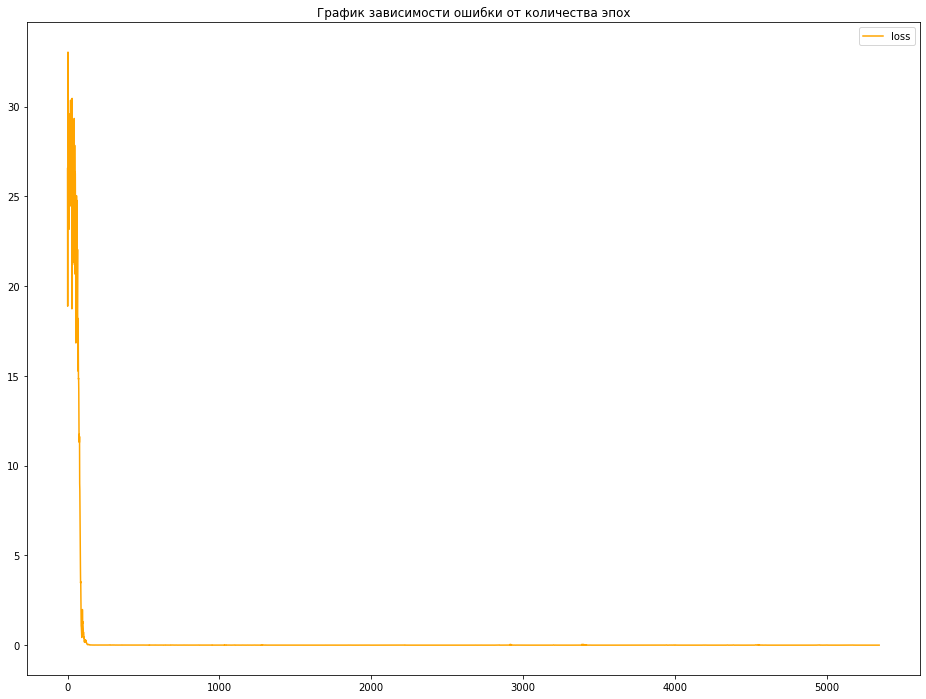

In [123]:
visualize_loss_history(loss_history)

In [124]:
def visualize_predictions(start_x: float, end_x: float, model: PINN) -> None:
  x_test = torch.linspace(start_x, end_x, 200)
  yh = model(x_test.view(-1,1))
  preds = yh.data.cpu().view(-1).numpy()
  ground_truth = f_real(x_test.view(-1,1))
  x_test = x_test.data.view(-1).numpy()
  ground_truth = ground_truth.view(-1).numpy()
  fig, ax = plt.subplots()
  fig.set_size_inches(16, 12)
  sns.lineplot(x=x_test, y=ground_truth, color='orange', label='Аналитическая фунцкия')
  sns.lineplot(x=x_test, y=preds, color='blue', label='Предсказание нейронной сети')
  ax.set_title('Сравнение настоящей функции и предсказание нейронной сети')
  ax.legend()
  plt.show()

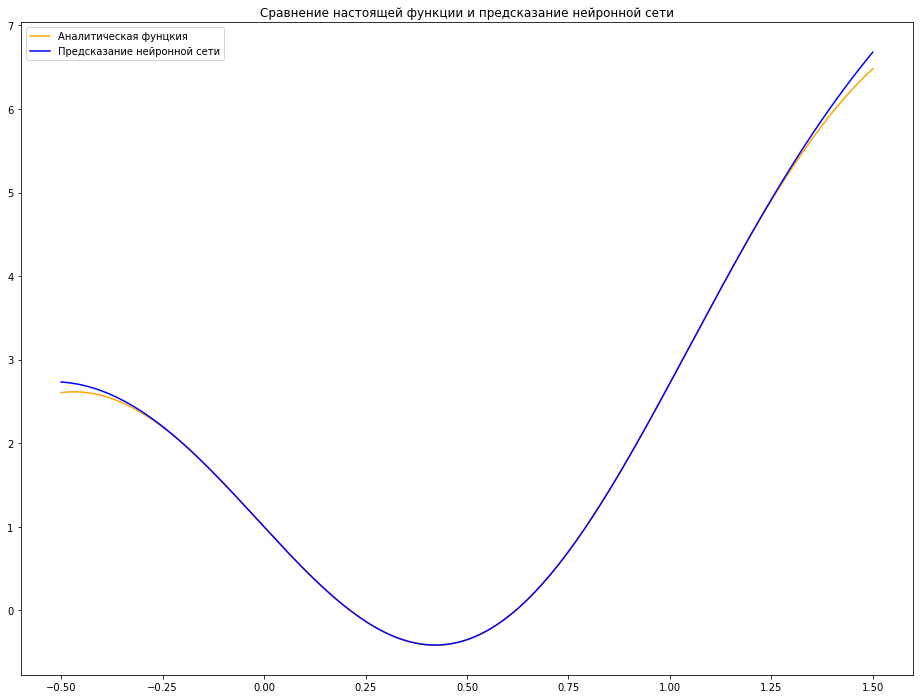

In [125]:
visualize_predictions(-0.5, 1.5, model)